# 3-1. 프로젝트 - Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


이전 노드에서 아래의 작업을 이미 수행하였다면 그냥 넘어가 주세요.

In [2]:
# 1) 데이터 확인
# $ ls -l ~/data

# 2) 프로젝트 폴더 생성
# $ mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# $ ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/Chapter_10_Recommendation_System_Exploring/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

* Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수와 아이템 수 입니다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## 1.1 기본 분석 - User Length

각 유저가 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.

In [6]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

여기서 user_length란 같은 UserId를 공유하는 데이터 row의 개수를 의미합니다. 여기서 UserId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자입니다. 로그인한 사용자가 최소한 특정 사용자의 행동을 UserId 기준으로 모아서 분류해낼 수는 있습니다. 따라서 여기서 user_length란 사용자가 로그인 했을때 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 됩니다.

In [7]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [8]:
df = data
df

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 1.2 Session time - Session의 정의 설정

### 시간 기반 기준: 사용자가 일정 시간(예: 30분) 동안 활동이 없으면 새로운 세션으로 간주.

In [9]:
# UTC 초 단위 시간을 yyyy-mm-dd 형식으로 변환
df['Timestamp'] = pd.to_datetime(df['Time'], unit='s')
df['Date'] = df['Timestamp'].dt.strftime('%Y-%m-%d')

print(df)

         UserId  ItemId  Rating       Time           Timestamp        Date
31            1    3186       4  978300019 2000-12-31 22:00:19  2000-12-31
22            1    1270       5  978300055 2000-12-31 22:00:55  2000-12-31
27            1    1721       4  978300055 2000-12-31 22:00:55  2000-12-31
37            1    1022       5  978300055 2000-12-31 22:00:55  2000-12-31
24            1    2340       3  978300103 2000-12-31 22:01:43  2000-12-31
...         ...     ...     ...        ...                 ...         ...
1000019    6040    2917       4  997454429 2001-08-10 14:40:29  2001-08-10
999988     6040    1921       4  997454464 2001-08-10 14:41:04  2001-08-10
1000172    6040    1784       3  997454464 2001-08-10 14:41:04  2001-08-10
1000167    6040     161       3  997454486 2001-08-10 14:41:26  2001-08-10
1000042    6040    1221       4  998315055 2001-08-20 13:44:15  2001-08-20

[1000209 rows x 6 columns]


In [10]:
# 시간 기준 세션 분리 (30분 이상 간격이 있을 경우 새로운 세션)

session_gap = pd.Timedelta(minutes=30)
df['SessionId'] = (df.groupby('UserId')['Timestamp']
                  .diff() > session_gap).cumsum()

In [11]:
print(df)

         UserId  ItemId  Rating       Time           Timestamp        Date  \
31            1    3186       4  978300019 2000-12-31 22:00:19  2000-12-31   
22            1    1270       5  978300055 2000-12-31 22:00:55  2000-12-31   
27            1    1721       4  978300055 2000-12-31 22:00:55  2000-12-31   
37            1    1022       5  978300055 2000-12-31 22:00:55  2000-12-31   
24            1    2340       3  978300103 2000-12-31 22:01:43  2000-12-31   
...         ...     ...     ...        ...                 ...         ...   
1000019    6040    2917       4  997454429 2001-08-10 14:40:29  2001-08-10   
999988     6040    1921       4  997454464 2001-08-10 14:41:04  2001-08-10   
1000172    6040    1784       3  997454464 2001-08-10 14:41:04  2001-08-10   
1000167    6040     161       3  997454486 2001-08-10 14:41:26  2001-08-10   
1000042    6040    1221       4  998315055 2001-08-20 13:44:15  2001-08-20   

         SessionId  
31               0  
22               0  


In [12]:
# 세션별 집계 예제
# 세션 시작 / 세션 종료
session_data = df.groupby(['UserId','SessionId']).agg({
    'Timestamp' : ['min', 'max']}).reset_index()

session_data

UserId SessionId           Timestamp                    
                                       min                 max
0          1         0 2000-12-31 22:00:19 2000-12-31 22:38:01
1          1         1 2001-01-06 23:35:39 2001-01-06 23:39:11
2          2         1 2000-12-31 21:28:44 2000-12-31 22:02:54
3          3         1 2000-12-31 21:10:18 2000-12-31 21:35:04
4          4         1 2000-12-31 20:18:44 2000-12-31 20:24:42
...      ...       ...                 ...                 ...
25158   6040     19119 2000-07-10 23:22:23 2000-07-10 23:36:06
25159   6040     19120 2000-07-28 23:52:32 2000-07-29 00:01:40
25160   6040     19121 2001-03-10 03:41:22 2001-03-10 03:41:22
25161   6040     19122 2001-08-10 14:29:22 2001-08-10 14:41:26
25162   6040     19123 2001-08-20 13:44:15 2001-08-20 13:44:15

[25163 rows x 4 columns]

## 1.3 Session Length

In [13]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         40
1        652
2        405
3          1
4         65
        ... 
19119      7
19120     14
19121      1
19122     21
19123      1
Length: 19124, dtype: int64

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미합니다. 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자입니다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있습니다. 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 됩니다.

In [14]:
session_length.median(), session_length.mean()

(3.0, 52.301244509516835)

In [15]:
session_length.min(), session_length.max()

(1, 2411)

In [16]:
session_length.quantile(0.999)

1362.128000000026

99.9% 세션은 길이가 1363이하입니다.

길이가 2411인 세션은 뭔가 이상합니다.

하나를 잡고 살펴봅시다.

In [17]:
long_session = session_length[session_length==2411].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,Timestamp,Date,SessionId
713899,4277,2307,3,1046193234,2003-02-25 17:13:54,2003-02-25,13660
713774,4277,2675,4,1046193325,2003-02-25 17:15:25,2003-02-25,13660
714328,4278,1198,4,965289624,2000-08-03 08:00:24,2000-08-03,13660
714357,4278,555,3,965289624,2000-08-03 08:00:24,2000-08-03,13660
714324,4278,2096,4,965289659,2000-08-03 08:00:59,2000-08-03,13660
...,...,...,...,...,...,...,...
716804,4291,2723,3,965274844,2000-08-03 03:54:04,2000-08-03,13660
716699,4291,2533,3,965274890,2000-08-03 03:54:50,2000-08-03,13660
716760,4291,2641,3,965274890,2000-08-03 03:54:50,2000-08-03,13660
716768,4291,442,2,965274890,2000-08-03 03:54:50,2000-08-03,13660


세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [18]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.331364
2       0.450167
3       0.506693
4       0.542617
5       0.568762
          ...   
1277    0.998745
1278    0.998797
1280    0.998850
1289    0.998902
1306    0.998954
Length: 749, dtype: float64

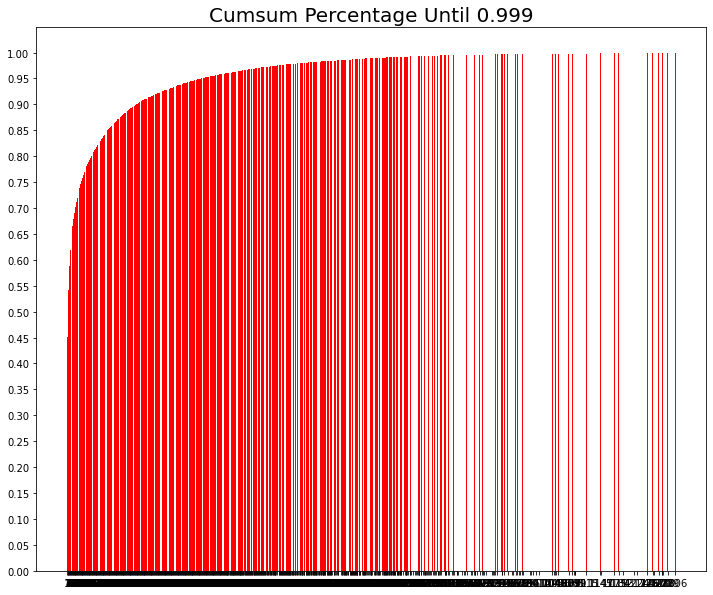

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [20]:
oldest, latest = df['Timestamp'].min(), df['Timestamp'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## 1.3 Data Cleansing

길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 2개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해 줍니다.

너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해 줍니다. 따라서 적게 클릭된 기준을 '5'로 잡겠습니다.

In [21]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(df: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(df)
        df = cleanse_short_session(df, shortest)
        df = cleanse_unpopular_item(df, least_click)
        after_len = len(df)
        if before_len == after_len:
            break
    return df


def cleanse_short_session(df: pd.DataFrame, shortest):
    session_len = df.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    df = df[df['SessionId'].isin(session_use)]
    return df


def cleanse_unpopular_item(df: pd.DataFrame, least_click):
    item_popular = df.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    df = df[df['ItemId'].isin(item_use)]
    return df

In [22]:
df = cleanse_recursive(df, shortest=2, least_click=5)
df

,UserId,ItemId,Rating,Time,Timestamp,Date,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,2000-12-31,0
22,1,1270,5,978300055,2000-12-31 22:00:55,2000-12-31,0
27,1,1721,4,978300055,2000-12-31 22:00:55,2000-12-31,0
37,1,1022,5,978300055,2000-12-31 22:00:55,2000-12-31,0
24,1,2340,3,978300103,2000-12-31 22:01:43,2000-12-31,0
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58,2001-08-10,19122
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,2001-08-10,19122
999988,6040,1921,4,997454464,2001-08-10 14:41:04,2001-08-10,19122
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,2001-08-10,19122


## 2.5 Train / Valid / Test split

모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.

대회에서 Test Set을 제공해 주고 있습니다. 한 번 살펴봅시다.

In [27]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Timestamp'].max()
    session_last_time = data.groupby('SessionId')['Timestamp'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
tr, test = split_by_date(df, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [29]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(df)}\n'
          f'\t Sessions: {df["SessionId"].nunique()}\n'
          f'\t Items: {df["ItemId"].nunique()}\n'
          f'\t First Time : {data["Timestamp"].min()}\n'
          f'\t Last Time : {data["Timestamp"].max()}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 993244
	 Sessions: 12770
	 Items: 3406
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-25 21:22:09

* valid Set Stats Info
	 Events: 993244
	 Sessions: 12770
	 Items: 3406
	 First Time : 2000-05-20 13:02:18
	 Last Time : 2003-02-27 14:22:07

* test Set Stats Info
	 Events: 993244
	 Sessions: 12770
	 Items: 3406
	 First Time : 2000-05-01 01:03:51
	 Last Time : 2003-02-28 17:49:50



In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 2-1. Data Pipeline
이전 스텝에서 개념을 정리해 본 Session-Parallel Mini-Batch 를 구현해 봅니다.

### 1.1 SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, df):
        self.df = df
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Timestamp,Date,SessionId,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,2000-12-31,0,0
22,1,1270,5,978300055,2000-12-31 22:00:55,2000-12-31,0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2000-12-31,0,2
37,1,1022,5,978300055,2000-12-31 22:00:55,2000-12-31,0,3
24,1,2340,3,978300103,2000-12-31 22:01:43,2000-12-31,0,4
36,1,1836,5,978300172,2000-12-31 22:02:52,2000-12-31,0,5
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,2000-12-31,0,7
47,1,1207,4,978300719,2000-12-31 22:11:59,2000-12-31,0,8
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,0,9


In [35]:
tr_dataset.click_offsets

array([     0,     40,    692, ..., 990517, 990531, 990552], dtype=int32)

In [36]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 12752, 12753, 12754])

## 4.2 SessionDataLoader
파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.
#### '자료' link: https://dojang.io/mod/page/view.php?id=2405

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Timestamp,Date,SessionId,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,2000-12-31,0,0
22,1,1270,5,978300055,2000-12-31 22:00:55,2000-12-31,0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2000-12-31,0,2
37,1,1022,5,978300055,2000-12-31 22:00:55,2000-12-31,0,3
24,1,2340,3,978300103,2000-12-31 22:01:43,2000-12-31,0,4
36,1,1836,5,978300172,2000-12-31 22:02:52,2000-12-31,0,5
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,2000-12-31,0,7
47,1,1207,4,978300719,2000-12-31 22:11:59,2000-12-31,0,8
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,0,9


In [39]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.

input, output, mask의 감을 잡아 봅시다.

In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  40 165  74]
Label Item Idx are :       [  1  41 514 728]
Previous Masked Input Idx are []


## Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 3.2 Model Architecture

스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [45]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3406)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  518700    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3406)              173706    
Total params: 692,406
Trainable params: 692,406
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [46]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [48]:
# <1차 검증>

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 0it [00:00, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 7